In [1]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import imutils
from sklearn.decomposition import PCA
import numpy as np
from scipy.stats import pearsonr
from scipy import signal
import matplotlib.patches as mpatches
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
import cv2
import numpy as np
from matplotlib import pyplot as plt

## Определение типа ЛА(миг-35, B1) по изображению с помощью логистической регрессии и метода главных компонент.


Попробуем научится отличать отечественный истребитель МиГ-35 от американского бомбардировщика B1 по картинкам из интернета.

План такой:
1. Предобработка
    - Находим границы на картинке(по градиенту), обрезаем картинку чтобы остались только границы.
    - Переводим картинку в массив точек, находим их главные компоненты.
    - Поворачиваем точки так, чтобы главная компонента смотрела вверх.
    - Превращаем точки обратно в изображение.
2. Обучение и тест
    - Берем 40 картинок из интернета: по 20 одного самолета и по 20 другого.
    - Все предобрабатываем, превращаем в одномерный массив, формируем массив ответов.
    - Делим на обучение и тест 50 на 50 : по 20 изображений каждого вида на группу, по 10 изображений на самолет.
    - Обучаем логистическую регрессию, каждый пиксель предобработанного изображения -- отдельный признак.
    - Считаем точность классификации.
   
   



Сначала посмотрим на картинки:

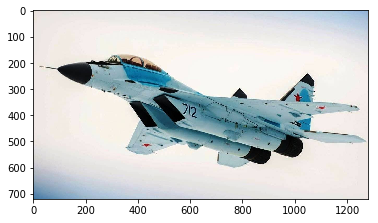

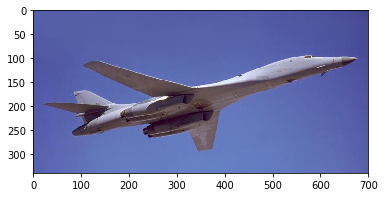

In [2]:
im = plt.imread('mig35/1.jpg')
plt.imshow(im)
plt.show()
im = plt.imread('b1/1.jpg')
plt.imshow(im)
plt.show()


Попробуем предобработать изображение. Для того, чтобы снизить влияние шумов (артефактов сжатия, облаков и т.п.) на поиск границ, можно применить билатеральный фильтр.

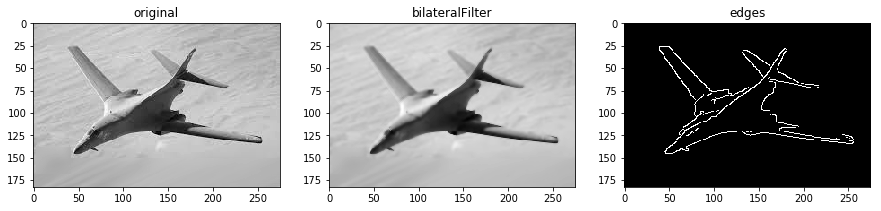

In [3]:
img = cv2.imread(f'b1/2.jpg',0)

#оригинальное изображение
plt.figure(figsize=(15,10))
plt.subplot(131)
plt.title('original')
plt.imshow(img,cmap='gray')

#билатеральный фильтр
img = cv2.bilateralFilter(img,5,75,75)
plt.subplot(132)
plt.title('bilateralFilter')
plt.imshow(img,cmap='gray')

#границы
img = cv2.Canny(img,75,160)   
plt.subplot(133)
plt.title('edges')
plt.imshow(img,cmap='gray')

plt.show()

Загрузим все картинки и найдем границы:

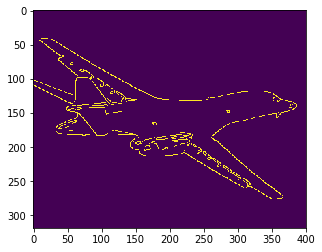

In [80]:

def find_edges(img):
    img = cv2.bilateralFilter(img,5,75,75)
    img = cv2.Canny(img,75,160)     
    return img


imgs_b1 = list()
imgs_mig35 = list()

for i in range(1,21):
    img = cv2.imread(f'b1/{i}.jpg',0)
    img = find_edges(img)  
    imgs_b1.append(img)
    
    img = cv2.imread(f'mig35/{i}.jpg',0)
    img = find_edges(img) 
    imgs_mig35.append(img)
    

    
plt.imshow(imgs_b1[5])
plt.show()
    

Попробуем построить PCA и повернуть точки по главным компонентам:

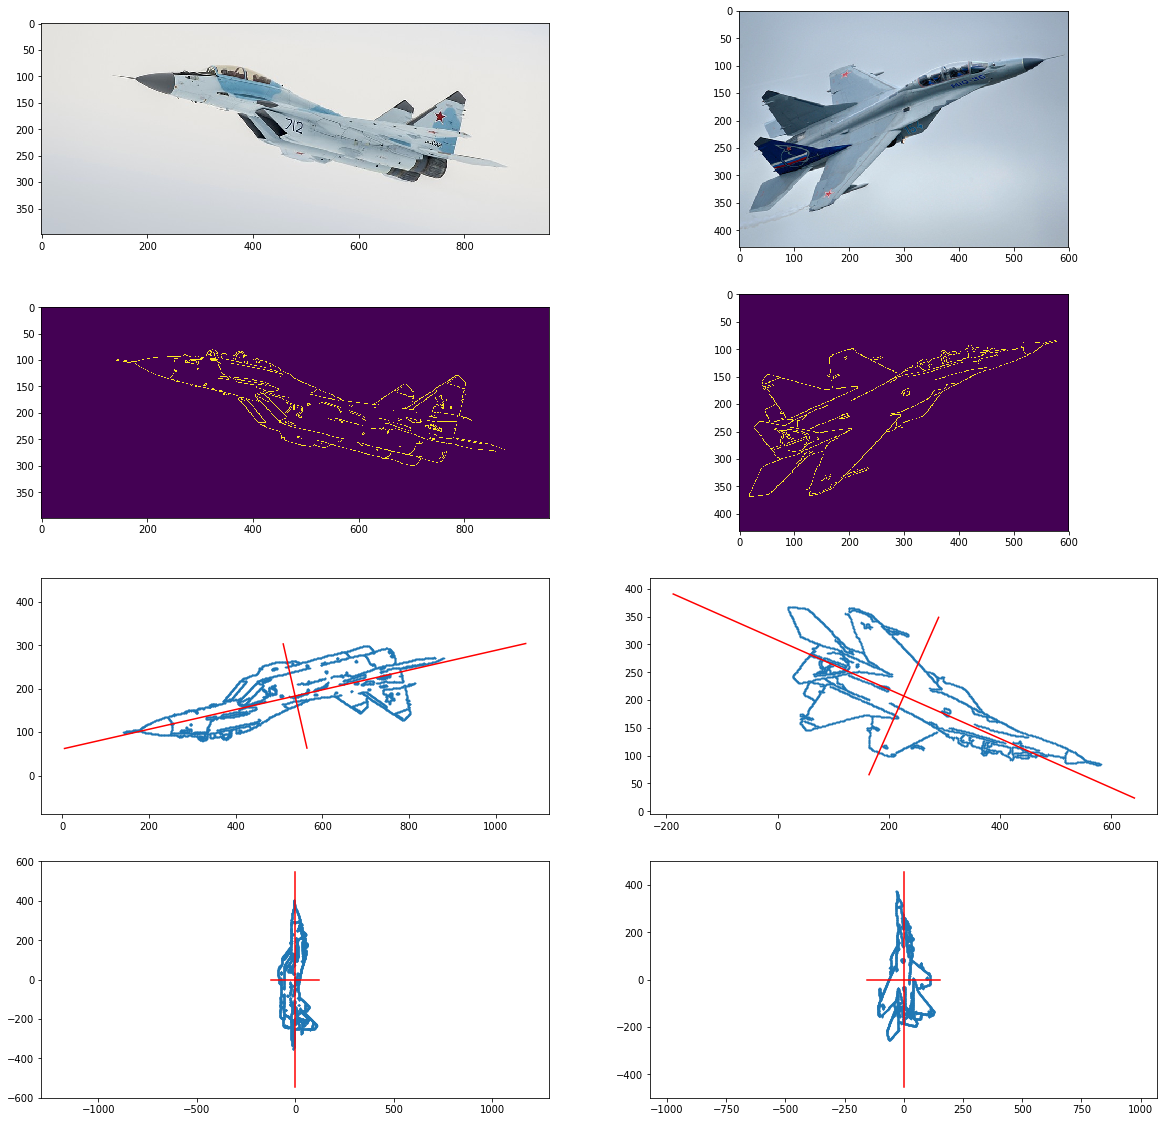

In [5]:
def plot_pca(model, data):
   
    center = data.mean(axis=0)
    
    ax0 = np.vstack([np.zeros(2),model.components_[0]])
    ax1 = np.vstack([np.zeros(2),model.components_[1]])
    ax0 = ax0*6 * np.sqrt(model.explained_variance_[0])
    ax1 = ax1*6 * np.sqrt(model.explained_variance_[1])

    ax0[0,:],ax0[1,:] = ax0[0,:] - ax0[1,:]/2, ax0[1,:] - ax0[1,:]/2
    ax1[0,:],ax1[1,:] = ax1[0,:] - ax1[1,:]/2, ax1[1,:] - ax1[1,:]/2
    ax0 = ax0 + center
    ax1 = ax1 + center

    plt.scatter(data[:,1], data[:,0],s=0.5)
    plt.plot(ax0[:,1],ax0[:,0],c='r')
    plt.plot(ax1[:,1],ax1[:,0],c='r')
    plt.axis('equal')
#     plt.show()
i=2
j=6
im = imgs_mig35[i]
data = np.argwhere(im>0)
model = PCA(n_components=2)
model.fit(data)


plt.figure(figsize=(20,20))

plt.subplot(421)
plt.imshow(plt.imread(f'mig35/{i+1}.jpg'))
plt.subplot(422)
plt.imshow(plt.imread(f'mig35/{j+1}.jpg'))

plt.subplot(423)
plt.imshow(imgs_mig35[i])
plt.subplot(424)
plt.imshow(imgs_mig35[j])

plt.subplot(425)
plot_pca(model,data)

im = imgs_mig35[j]
data2 = np.argwhere(im>0)
model2 = PCA(n_components=2)
model2.fit(data2)

plt.subplot(426)
plot_pca(model2,data2)

plt.subplot(427)
plot_pca(PCA(n_components=2).fit(model.transform(data)),model.transform(data))


plt.subplot(428)
plot_pca(PCA(n_components=2).fit(model2.transform(data2)),model2.transform(data2))

plt.show()



Видно, что изначально не очень похожие картинки стали очень похожи.

Теперь проделаем то же со всеми картинками.

In [6]:

def preprocess(img,im_width = 720, c_size = 5):
    
    #переводим изображение в координаты точек
    data = np.argwhere(img>0)
    #нормируем
    scaled_data = data#/ data.std(axis=0)
    
    #преобразуем методом главных компонент
    model = PCA(n_components=2)
    model.fit(scaled_data)
    tdata = model.transform(scaled_data) 
    
    #масштабируем для перевода точек обратно в изображение
    im_width = 720
   
    points = (tdata - tdata.min(axis=0))/((tdata.max(axis=0) - tdata.min(axis=0)).max())

    offset = (1 - (points.max(axis=0) - points.min(axis=0)))/2
    
    im_points = ((points+offset)*im_width).astype(int)
       
    
    #рисуем точки    
    image = np.zeros((im_width,im_width))
    for point in im_points:
        image = cv2.circle(image,tuple(point),c_size,1,-1)
    return image

In [39]:
imgs_mig = [preprocess(img).flatten() for img in imgs_mig35]
imgs_b1  = [preprocess(img).flatten() for img in imgs_b1]

Разделим всю выборку на обучение и тест (50 на 50), построим ленейную регрессию и посчитаем точность:

In [51]:
%%time
import random
indexes = list(range(20))
random.shuffle(indexes)

alldata = np.vstack([np.array(imgs_mig)[indexes[:len(indexes)//2]],np.array(imgs_b1)[indexes[:len(indexes)//2]]])
labels  = np.array([0]*(len(indexes)//2) + [1]*(len(indexes)//2))

test = np.vstack([np.array(imgs_mig)[indexes[len(indexes)//2:]],np.array(imgs_b1)[indexes[len(indexes)//2:]]])

labels_test = np.array([0]*(len(indexes)//2) + [1]*(len(indexes)//2))

text_labels = np.array(['mig35','b1'])

reg = LogisticRegression(solver='lbfgs')
reg.fit(alldata,labels)
score = reg.score(test,labels_test)
print(f'score = {score}')

score = 0.95
Wall time: 3.46 s


Точность получилась очень высокая.

Посмотрим на изображения и предсказанные классы из тестовой выборки:

In [9]:
def predict_aircraft(img):
    img = find_edges(img)
    img = preprocess(img).flatten().reshape(1, -1)
    pred = reg.predict_proba(img)    
    lab = text_labels[np.argmax(pred)]
    p = pred.max()
    return lab,p
    

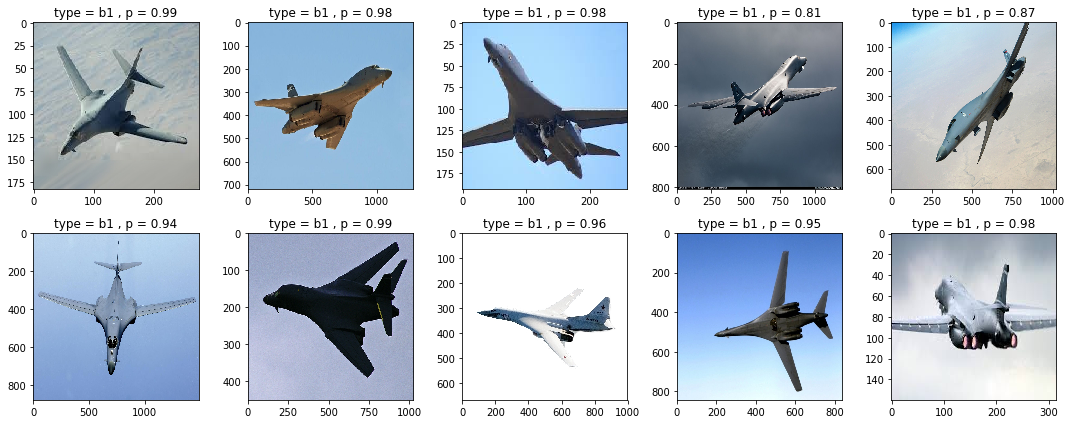

In [76]:
plt.figure(figsize=(15,6))
for ix,i in enumerate(indexes[10:]):
    file = f'b1/{i+1}.jpg'
    img = cv2.imread(file,0)
    pred = predict_aircraft(img)
    plt.subplot(2,5,ix+1)
    plt.title("type = %s , p = %.2f" % pred)
    plt.imshow(plt.imread(file),aspect="auto")
plt.tight_layout()
plt.show()

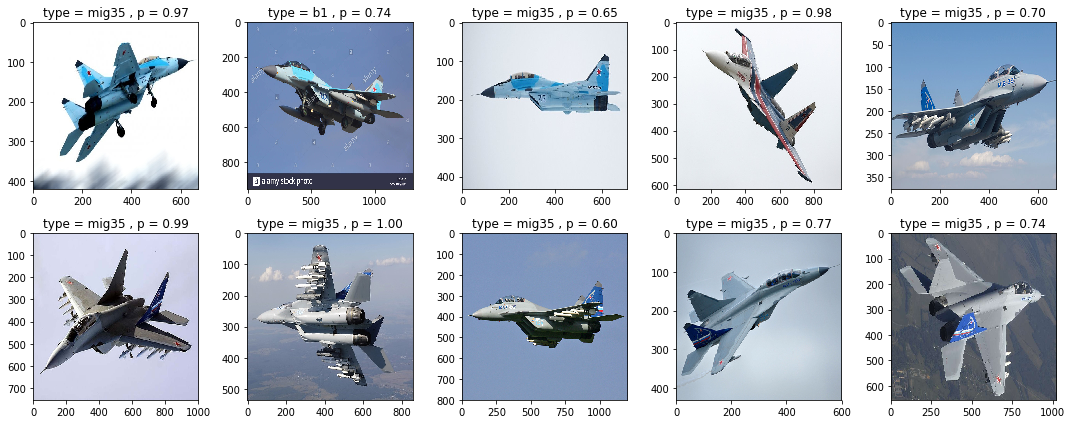

In [75]:
plt.figure(figsize=(15,6))
for ix,i in enumerate(indexes[10:]):
    file = f'mig35/{i+1}.jpg'
    img = cv2.imread(file,0)
    pred = predict_aircraft(img)
    plt.subplot(2,5,ix+1)
    plt.title("type = %s , p = %.2f" % pred)
    plt.imshow(plt.imread(file),aspect="auto")
plt.tight_layout()
plt.show()

Посмотрим на веса:

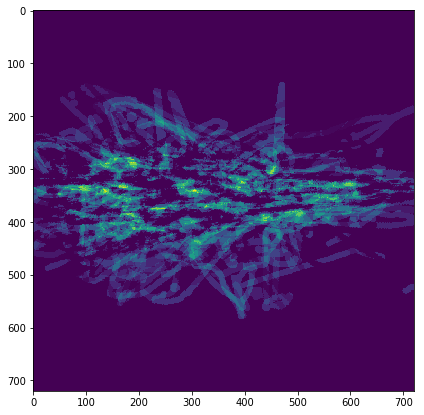

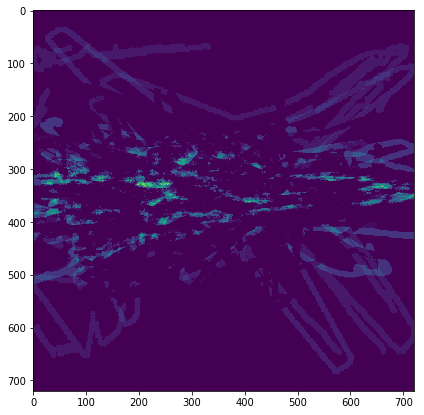

In [77]:
c = reg.coef_.copy().reshape(720,720)
c_mig = np.where(c>0,c,0)
c_b1 = np.where(c<0,-c,0)
plt.figure(figsize=(7,7))
plt.imshow(c_b1)
plt.show()
plt.figure(figsize=(7,7))
plt.imshow(c_mig)
plt.show()